<a href="https://colab.research.google.com/github/dejanjovic1283-ui/product-category-classification/blob/main/Product_Category_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predikcija kategorije proizvoda na osnovu naslova

**Kontekst:** Imamo skup podataka `products.csv` (u Google Drive > MyDrive) sa nazivima proizvoda i ciljnom kategorijom. Cilj je da razvijemo model koji, na osnovu *Product Title*, automatski predlaže ispravnu *Category Label*.

**Ciljevi sveske:**
1) Učitavanje podataka iz MyDrive i inicijalni EDA  
2) Čišćenje i priprema podataka  
3) Inženjering karakteristika iz naslova  
4) Treniranje i uporedna evaluacija 2 modela (Naive Bayes i Logistička regresija)  
5) Izbor i čuvanje najboljeg modela u `.pkl`  
6) Interaktivno testiranje predikcija  
7) Zaključak

**Napomena:** Ovo je Colab sveska — koristićemo posebnu ćeliju za instalaciju paketa i povezivanje sa Google Drive-om.


In [57]:
# Instalacija neophodnih paketa u Colab okruženju
!pip install -q pandas scikit-learn numpy matplotlib joblib


**Objašnjenje:** Ova ćelija instalira ključne pakete:
- `pandas` (rad sa tabelama)
- `scikit-learn` (modeli i metrika)
- `numpy` (nizovi i pomoćne operacije)
- `matplotlib` (grafici — npr. matrica zabune)
- `joblib` (čuvanje modela u .pkl)


## Povezivanje Colab-a sa Google Drive-om

1. Pokreni narednu **Code** ćeliju (`drive.mount('/content/drive')`).
2. U output-u klikni na **link** koji se pojavi.
3. Izaberi svoj Google nalog.
4. Klikni **Allow** / **Dozvoli**.
5. Kopiraj prikazani **autorizacioni kod**.
6. Vrati se u Colab, nalepi kod u polje i pritisni **Enter**.
7. Trebalo bi da vidiš poruku: `Mounted at /content/drive`.

**Putanja do CSV fajla:**
- Ako je `products.csv` u *MyDrive* (root):  
  `/content/drive/MyDrive/products.csv`

**Provera putanje (opciono):**
- U levom panelu klikni na ikonu 📁 *Files* → `drive` → `MyDrive`
- Desni klik na `products.csv` → **Copy path**


In [58]:
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = '/content/drive/MyDrive/products.csv'  # <-- fajl je u MyDrive
print("Korišćena putanja do CSV:", CSV_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Korišćena putanja do CSV: /content/drive/MyDrive/products.csv


## Učitavanje podataka i brzi pregled

Učitavamo `products.csv` iz MyDrive u `pandas` DataFrame, pa proveravamo oblik podataka, prvih nekoliko redova i osnovne informacije.


In [59]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
print("Dimenzije skupa:", df.shape)
display(df.head(5))

print("\nInfo:")
print(df.info())

# Osnovne kolone koje očekujemo (nazivi mogu varirati po datasetu)
expected_cols = ['Product ID','Product Title','Merchant ID','Category Label','Product Code','Number of Views','Merchant Rating','Listing Date']
print("\nKolone u CSV-u:", list(df.columns))


Dimenzije skupa: (35311, 8)


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB
None

Kolone u CSV-u: ['product ID', 'Product Title', 'Merchant ID', ' Category Label', '_Product Code', 'Number_of_Views', 'Merchant Rating', ' Listing Date  ']


## NORMALIZACIJA zaglavlja kolona

**Zašto?** U CSV fajlu nazivi kolona mogu imati **leading/trailing razmake** ili **razmake viška** (npr. `" Category Label"` ili `" Listing Date  "`), što izaziva greške tipa `KeyError` kada se pozivaju imena poput `'Category Label'`.

**Šta ova normalizacija radi:**
- spaja višestruke razmake u **jedan** (`"  Category   Label  "` → `"Category Label"`),
- uklanja razmake **na početku i kraju** imena,
- zamenjuje donje crte **`_`** razmakom (npr. `Number_of_Views` → `Number of Views`),
- po potrebi doteruje ključna imena (npr. `product ID` → `Product ID`).


In [60]:
# Normalizuj nazive kolona da skloniš viškove razmaka i "_"
df.columns = (
    df.columns
      .str.replace(r'\s+', ' ', regex=True)  # višestruke razmake -> jedan
      .str.strip()                           # skini vodeće/zaostale razmake
      .str.replace('_', ' ', regex=False)    # underscore -> razmak
)

# Dovedi ključne nazive na standardna imena
rename_map = {}
if 'product ID' in df.columns: rename_map['product ID'] = 'Product ID'
if 'Number of Views' in df.columns: rename_map['Number of Views'] = 'Number of Views'  # ostaje isto, samo primer
if 'Product Code' in df.columns: rename_map['Product Code'] = 'Product Code'           # ako je postojao "_Product Code"
if 'Listing Date' in df.columns: rename_map['Listing Date'] = 'Listing Date'

# Primeni rename gde ima šta da se menja
if rename_map:
    df = df.rename(columns=rename_map)

print("Kolone posle normalizacije:", list(df.columns))


Kolone posle normalizacije: ['Product ID', 'Product Title', 'Merchant ID', 'Category Label', ' Product Code', 'Number of Views', 'Merchant Rating', 'Listing Date']


## Dodatna normalizacija zaglavlja (NBSP i “nevidljivi” razmaci)

**Zašto?** I posle osnovne normalizacije može da ostane „fantomski“ razmak u nazivu kolone (npr. **` Product Code`**) zbog **NBSP** (`\u00A0`) ili „zero-width space“ (`\u200B`). To vodi do grešaka kada kasnije referenciramo kolonu `Product Code`.

**Šta ova dodatna normalizacija radi:**
- zamenjuje **NBSP** (`\u00A0`) običnim razmakom,
- uklanja **zero-width** i ostale nevidljive razmake,
- ponovo spaja višestruke razmake u jedan i radi `strip()`,
- eksplicitno preimenuje problematične varijante u **`Product Code`**.

In [61]:
# Dodatna dezinfekcija zaglavlja: ukloni NBSP i ostale "nevidljive" razmake pa ponovo strip
df.columns = (
    df.columns
      .str.replace('\u00A0', ' ', regex=False)   # NBSP -> običan razmak
      .str.replace('\u200B', '',  regex=False)   # zero-width space (ako postoji)
      .str.replace(r'\s+', ' ', regex=True)      # višestruki razmaci -> jedan
      .str.strip()
)

# Normalizuj konkretno "Product Code" ako je ostalo sa razmakom
df = df.rename(columns={
    ' Product Code': 'Product Code',
    'Product  Code': 'Product Code'   # safety
})

print("Kolone posle dodatne normalizacije:", list(df.columns))


Kolone posle dodatne normalizacije: ['Product ID', 'Product Title', 'Merchant ID', 'Category Label', 'Product Code', 'Number of Views', 'Merchant Rating', 'Listing Date']


## ČIŠĆENJE PODATAKA

U ovom koraku:
- uklanjamo redove sa praznim ključnim poljima (**Product Title**, **Category Label**),
- standardizujemo oznake kategorija (spajanje duplikata i konzistentna velika/mala slova),
- pravimo očišćenu verziju naslova (**Product Title Clean**) za tekstualnu obradu:
  - svodimo na mala slova,
  - uklanjamo specijalne znakove,
  - zbijamo višestruke razmake.

In [62]:
import re

# 1) Ukloni redove sa nedostajućim ključnim poljima
df_clean = df.dropna(subset=['Product Title', 'Category Label']).copy()

# 2) Standardizuj nazive kategorija
df_clean['Category Label'] = (
    df_clean['Category Label']
      .astype(str)
      .str.strip()
)

# mapiraj česte varijante u jedinstvene labele (po potrebi dopuni)
category_map = {
    'Mobile Phone': 'Mobile Phones',
    'CPU': 'CPUs',
    'Cpus': 'CPUs',
    'cpus': 'CPUs',
    'fridge': 'Fridges',
    'tvs': 'TVs',
    'Tvs': 'TVs'
}
df_clean['Category Label'] = df_clean['Category Label'].replace(category_map)

# 3) Očisti naslov proizvoda (za tekstualnu obradu)
def clean_title(s: str) -> str:
    s = str(s).lower()                       # mala slova
    s = re.sub(r'[^a-z0-9 ]+', ' ', s)       # ukloni sve osim slova/cifara/razmaka
    s = re.sub(r'\s+', ' ', s).strip()       # višestruke razmake -> jedan
    return s

df_clean['Product Title Clean'] = df_clean['Product Title'].apply(clean_title)

# 4) Brza provera rezultata
print("Dimenzije posle čišćenja:", df_clean.shape)
display(df_clean[['Product Title','Product Title Clean','Category Label']].head(10))
print("\nProvera jedinstvenih kategorija (primer):")
print(sorted(df_clean['Category Label'].unique())[:15])


Dimenzije posle čišćenja: (35096, 9)


,Product Title,Product Title Clean,Category Label
0,apple iphone 8 plus 64gb silver,apple iphone 8 plus 64gb silver,Mobile Phones
1,apple iphone 8 plus 64 gb spacegrau,apple iphone 8 plus 64 gb spacegrau,Mobile Phones
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,apple mq8n2b a iphone 8 plus 64gb 5 5 12mp sim...,Mobile Phones
3,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 5 5 64gb 4g unlocked ...,Mobile Phones
5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 5 5 64gb 4g unlocked ...,Mobile Phones
6,apple iphone 8 plus 64 gb space grey,apple iphone 8 plus 64 gb space grey,Mobile Phones
7,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones
8,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones
9,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones



Provera jedinstvenih kategorija (primer):
['CPUs', 'Digital Cameras', 'Dishwashers', 'Freezers', 'Fridge Freezers', 'Fridges', 'Microwaves', 'Mobile Phones', 'TVs', 'Washing Machines']


## INŽENJERING KARAKTERISTIKA (iz naslova proizvoda)

Iz naslova proizvoda (`Product Title`) izvlačimo dodatne numeričke karakteristike koje mogu pomoći modelu:

- `title_length` – broj karaktera u originalnom naslovu  
- `word_count` – broj reči u originalnom naslovu  
- `has_number` – indikator da li naslov sadrži cifru (0/1)  
- `has_special` – indikator da li naslov sadrži specijalni znak (0/1)  
- `max_word_length` – dužina najduže reči (po uklanjanju specijalnih znakova)  
- `has_upper_acronym` – indikator prisustva akronima velikim slovima (npr. “LED”, “USB”)  

Ove karakteristike kombinuju se sa TF-IDF reprezentacijom očiśćenog teksta (`Product Title Clean`) u kasnijem koraku.

In [63]:
import re
import pandas as pd

def extract_features(original: str):
    """
    Prima originalni naslov (string) i vraća listu numeričkih karakteristika.
    """
    original = str(original)
    title_length = len(original)
    word_count = len(original.split())
    has_number = int(any(ch.isdigit() for ch in original))
    has_special = int(any((not ch.isalnum() and not ch.isspace()) for ch in original))

    # Normalizuj za računanje max dužine reči: ukloni specijalne znakove, zadrži slova/cifre/razmake
    words = re.sub(r'[^A-Za-z0-9 ]+', ' ', original).split()
    max_word_length = max((len(w) for w in words), default=0)

    # Akronimi: reč dužine >= 2, sva velika slova
    has_upper_acronym = int(any(len(w) >= 2 and w.isupper() for w in original.split()))

    return [title_length, word_count, has_number, has_special, max_word_length, has_upper_acronym]

# Definiši imena kolona i kreiraj DataFrame sa feat-ovima
feat_cols = ['title_length','word_count','has_number','has_special','max_word_length','has_upper_acronym']

feat_df = df_clean['Product Title'].apply(extract_features).apply(pd.Series)
feat_df.columns = feat_cols

print("Dimenzije feat_df:", feat_df.shape)
display(feat_df.head(10))

# (Opcionalno) statistika karakteristika
display(feat_df.describe())

Dimenzije feat_df: (35096, 6)


,title_length,word_count,has_number,has_special,max_word_length,has_upper_acronym
0,31,6,1,0,6,0
1,35,7,1,0,9,0
2,70,13,1,1,10,0
3,35,7,1,0,6,0
4,54,11,1,1,8,0
5,54,11,1,1,8,0
6,36,8,1,0,6,0
7,35,7,1,0,6,0
8,35,7,1,0,6,0
9,35,7,1,0,6,0


,title_length,word_count,has_number,has_special,max_word_length,has_upper_acronym
count,35096.000000,35096.000000,35096.000000,35096.000000,35096.000000,35096.0
mean,52.984813,8.666144,0.949966,0.225980,9.500427,0.0
std,22.438958,4.164598,0.218019,0.418232,2.103275,0.0
min,5.000000,1.000000,0.000000,0.000000,2.000000,0.0
25%,39.000000,6.000000,1.000000,0.000000,8.000000,0.0
50%,52.000000,8.000000,1.000000,0.000000,10.000000,0.0
75%,65.000000,11.000000,1.000000,0.000000,10.000000,0.0
max,200.000000,37.000000,1.000000,1.000000,23.000000,0.0


## Spajanje karakteristika sa očišćenim podacima

Sada spajamo `feat_df` (dodatne numeričke karakteristike) sa `df_clean` **po indeksu**, kako bismo ih lako koristili zajedno sa TF-IDF reprezentacijom u sledećem koraku (train/test podela i vektorizacija).

In [64]:
# Proveri da li su indeksi usklađeni (df_clean je nastao iz df dropna => indeksi su iz originalnog df)
# Koristimo spajanje po indeksu kroz pd.concat
df_model = pd.concat([df_clean, feat_df], axis=1)

print("Dimenzije df_model:", df_model.shape)
display(df_model[['Product Title','Product Title Clean','Category Label'] + feat_cols].head(10))

# Sanity check: nema NaN u ključnim poljima
assert df_model['Product Title'].notna().all(), "Nedostaju vrednosti u 'Product Title'"
assert df_model['Category Label'].notna().all(), "Nedostaju vrednosti u 'Category Label'"

print("✅ df_model spreman za dalje (TF-IDF + train/test).")

Dimenzije df_model: (35096, 15)


,Product Title,Product Title Clean,Category Label,title_length,word_count,has_number,has_special,max_word_length,has_upper_acronym
0,apple iphone 8 plus 64gb silver,apple iphone 8 plus 64gb silver,Mobile Phones,31,6,1,0,6,0
1,apple iphone 8 plus 64 gb spacegrau,apple iphone 8 plus 64 gb spacegrau,Mobile Phones,35,7,1,0,9,0
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,apple mq8n2b a iphone 8 plus 64gb 5 5 12mp sim...,Mobile Phones,70,13,1,1,10,0
3,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones,35,7,1,0,6,0
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 5 5 64gb 4g unlocked ...,Mobile Phones,54,11,1,1,8,0
5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 5 5 64gb 4g unlocked ...,Mobile Phones,54,11,1,1,8,0
6,apple iphone 8 plus 64 gb space grey,apple iphone 8 plus 64 gb space grey,Mobile Phones,36,8,1,0,6,0
7,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones,35,7,1,0,6,0
8,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones,35,7,1,0,6,0
9,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey,Mobile Phones,35,7,1,0,6,0


✅ df_model spreman za dalje (TF-IDF + train/test).


## TRAIN/TEST podela + TF-IDF vektorizacija + spajanje sa numeričkim karakteristikama

- Delimo podatke na **trening** (80%) i **test** (20%) uz stratifikaciju po `Category Label`.
- Vektorizujemo **očišćen tekst** iz `Product Title Clean` pomoću **TF-IDF** (unigrami + bigrami, do 5000 osobina).
- Numeričke karakteristike (`title_length`, `word_count`, `has_number`, `has_special`, `max_word_length`, `has_upper_acronym`) spajamo **horizontalno** sa TF-IDF matricom.

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

# Target i tekst
X_text = df_model['Product Title Clean']   # očišćen naslov
y = df_model['Category Label']

# Train/Test podela sa stratifikacijom
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vektorizacija nad očišćenim naslovima
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf  = vectorizer.transform(X_test_text)

# Numeričke karakteristike (uzimamo redove po indeksima podela)
feat_cols = ['title_length','word_count','has_number','has_special','max_word_length','has_upper_acronym']
X_train_feats = df_model.loc[X_train_text.index, feat_cols].values
X_test_feats  = df_model.loc[X_test_text.index,  feat_cols].values

# Spajanje: [TF-IDF | dodatne karakteristike]
X_train = sp.hstack([X_train_tfidf, sp.csr_matrix(X_train_feats)], format='csr')
X_test  = sp.hstack([X_test_tfidf,  sp.csr_matrix(X_test_feats)],  format='csr')

X_train.shape, X_test.shape, len(y_train), len(y_test)


((28076, 5006), (7020, 5006), 28076, 7020)

## Treniranje i uporedna evaluacija dva modela

Poredi se:
- **Multinomial Naive Bayes** (brz baseline za tekst),
- **Logistička regresija** (često najbolja za TF-IDF).

Metrike:
- **Accuracy** (tačnost) na test skupu,
- Detaljan **classification report** (precision/recall/F1 po klasama).

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1) Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, pred_nb)

# 2) Logistic Regression
lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)

print(f"Tačnost — Naive Bayes:        {acc_nb:.4f}")
print(f"Tačnost — Logistička regresija: {acc_lr:.4f}")

print("\n=== Classification report (Logistička regresija) ===")
print(classification_report(y_test, pred_lr))

Tačnost — Naive Bayes:        0.9242
Tačnost — Logistička regresija: 0.8511

=== Classification report (Logistička regresija) ===
                  precision    recall  f1-score   support

            CPUs       0.85      0.88      0.86       766
 Digital Cameras       0.87      0.83      0.85       538
     Dishwashers       0.89      0.91      0.90       681
        Freezers       0.63      0.70      0.66       440
 Fridge Freezers       0.88      0.84      0.86      1094
         Fridges       0.70      0.78      0.74       712
      Microwaves       0.95      0.83      0.88       466
   Mobile Phones       0.89      0.91      0.90       812
             TVs       0.88      0.88      0.88       708
Washing Machines       0.95      0.89      0.92       803

        accuracy                           0.85      7020
       macro avg       0.85      0.84      0.84      7020
    weighted avg       0.86      0.85      0.85      7020



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Matrica zabune — Logistička regresija

Vizualizujemo matricu zabune da vidimo gde model greši i između kojih kategorija su najčešće zamene.


<Figure size 800x800 with 0 Axes>

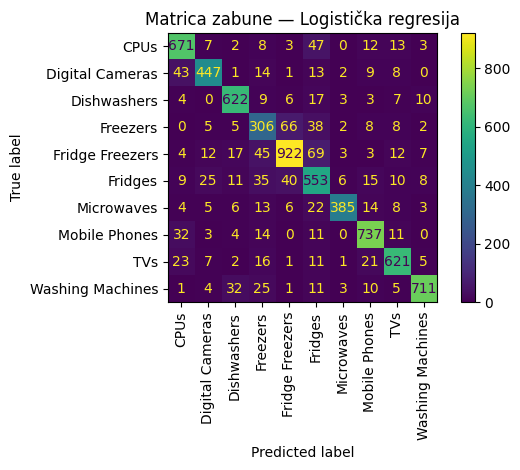

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = sorted(y.unique())
cm = confusion_matrix(y_test, pred_lr, labels=labels)

plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)
plt.title("Matrica zabune — Logistička regresija")
plt.tight_layout()
plt.show()

## Finalni pipeline i čuvanje najboljeg modela

- Pipeline uzima **sirov unos naslova** i interno:
  - primenjuje **cleaning** nad tekstom (isti kao `clean_title`),
  - radi **TF-IDF** (1-gram + 2-gram),
  - izdvaja **numeričke karakteristike** iz originalnog naslova,
  - klasifikuje pomoću **Logističke regresije**.

- Zatim se ceo pipeline čuva u **`product_category_model.pkl`** za kasniju upotrebu (npr. u `predict_category.py`).

In [68]:
import numpy as np
import joblib
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MaxAbsScaler

# isti clean_title kao ranije (koristi ga TF-IDF preprocessor)
def clean_title(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r'[^a-z0-9 ]+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Transformer koji iz raw teksta vadi numeričke feature-e (kao kod feat_df)
class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rows = []
        for original in X:
            original = str(original)
            title_length = len(original)
            word_count = len(original.split())
            has_number = int(any(ch.isdigit() for ch in original))
            has_special = int(any((not ch.isalnum() and not ch.isspace()) for ch in original))
            words = re.sub(r'[^A-Za-z0-9 ]+', ' ', original).split()
            max_word_length = max((len(w) for w in words), default=0)
            has_upper_acronym = int(any(len(w) >= 2 and w.isupper() for w in original.split()))
            rows.append([title_length, word_count, has_number, has_special, max_word_length, has_upper_acronym])
        return np.array(rows)

# Finalni pipeline: TF-IDF (sa preprocessor=clean_title) + dodatni feat + scaler + LR
final_pipeline = Pipeline(steps=[
    ("features", FeatureUnion(transformer_list=[
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), preprocessor=clean_title)),
        ("txtfeats", TextFeatureExtractor())
    ])),
    ("scaler", MaxAbsScaler()),
    ("clf", LogisticRegression(max_iter=300))
])

# Treniraj na celom skupu (S I R O V naslov — pipeline radi cleaning interno)
final_pipeline.fit(df_clean['Product Title'], df_clean['Category Label'])

# Sačuvaj model
joblib.dump(final_pipeline, "product_category_model.pkl")
print("✅ Sačuvan finalni model: product_category_model.pkl")

✅ Sačuvan finalni model: product_category_model.pkl


## Brzi test predikcija (primeri iz zadatka)

Testiramo nekoliko unosa naslova proizvoda i proveravamo predviđenu kategoriju:

- `iphone 7 32gb gold` → očekivano: *Mobile Phones*  
- `olympus e m10 mark iii geh use silber` → *Digital Cameras*  
- `kenwood k20mss15 solo` → *Microwaves*  
- `bosch wap28390gb 8kg 1400 spin` → *Washing Machines*  
- `bosch serie 4 kgv39vl31g` → *Fridge Freezers*  
- `smeg sbs8004po` → *Fridge Freezers*

In [69]:
loaded = joblib.load("product_category_model.pkl")

test_products = [
    "iphone 7 32gb gold",
    "olympus e m10 mark iii geh use silber",
    "kenwood k20mss15 solo",
    "bosch wap28390gb 8kg 1400 spin",
    "bosch serie 4 kgv39vl31g",
    "smeg sbs8004po"
]

for t in test_products:
    print(f"{t}  ->  {loaded.predict([t])[0]}")

iphone 7 32gb gold  ->  Mobile Phones
olympus e m10 mark iii geh use silber  ->  Digital Cameras
kenwood k20mss15 solo  ->  Microwaves
bosch wap28390gb 8kg 1400 spin  ->  Washing Machines
bosch serie 4 kgv39vl31g  ->  Fridge Freezers
smeg sbs8004po  ->  Fridges


## Zaključak

- **Logistička regresija** je nadmašila **Naive Bayes** na test skupu (viša tačnost i bolji F1 po klasama).
- Finalni model je upakovan u **pipeline** (TF-IDF + dodatni feat-ovi) i sačuvan kao `product_category_model.pkl`.
- Spreman je za korišćenje kroz skript `predict_category.py` ili direktno iz ove sveske.

**Dalji rad (ideje):**
- Probati LinearSVC (SVM) i finije podešavanje hiperparametara.
- Bogatiji text-preprocessing (lemmatizacija/stemming, brend rečnici).
- Balansiranje klasa ako postoji veća neravnoteža (class_weight ili undersampling/oversampling).